PyAutoLens
==========

**PyAutoLens** is software for analysing strong gravitational lenses, an astrophysical phenomenon where a galaxy
appears multiple times because its light is bent by the gravitational field of an intervening foreground lens galaxy.

Here is a schematic of a strong gravitational lens:

![Schematic of Gravitational Lensing](https://raw.githubusercontent.com/Jammy2211/PyAutoLens/master/docs/overview/images/lensing/schematic.jpg)
**Credit: F. Courbin, S. G. Djorgovski, G. Meylan, et al., Caltech / EPFL / WMKO**
https://www.astro.caltech.edu/~george/qsolens/

This notebook gives an overview of **PyAutoLens**'s features and API.

Lets first import autolens, its plotting module and the other libraries we'll need.

In [1]:
%matplotlib inline

import autolens as al
import autolens.plot as aplt

from astropy import cosmology as cosmo
import matplotlib.pyplot as plt
from os import path

Lensing
-------
First, we illustrate lensing calculations in **PyAutoLens** by creating an an image of a strong lens.

To describe the deflection of light, **PyAutoLens** uses `Grid2D` data structures, which are two-dimensional
Cartesian grids of (y,x) coordinates.

Below, we make and plot a uniform Cartesian grid:

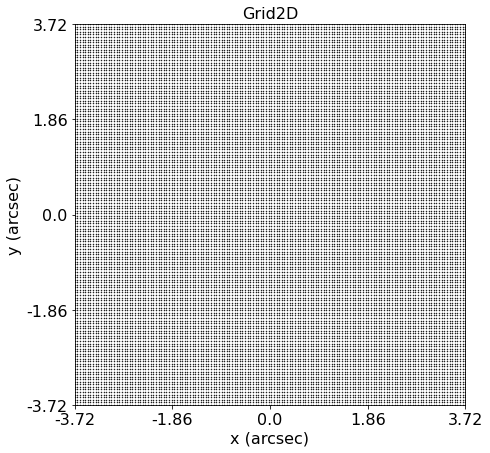

In [2]:
grid = al.Grid2D.uniform(
    shape_native=(150, 150),
    pixel_scales=0.05,  # <- The pixel-scale describes the conversion from pixel units to arc-seconds.
)

grid_plotter = aplt.Grid2DPlotter(grid=grid)
grid_plotter.figure_2d()

Our aim is to create an image of the source galaxy after its light has been deflected by the mass of the foreground
lens galaxy. We therefore need to ray-trace the `Grid2D`'s coordinates from the 'image-plane' to the 'source-plane'.

We therefore need analytic functions representing a galaxy's light and mass distributions. For this,  **PyAutoLens**
uses `Profile` objects, for example an ellipical sersic `LightProfile` object which represents a light distribution:

In [3]:
sersic_light_profile = al.lp.EllSersic(
    centre=(0.0, 0.0),
    elliptical_comps=(0.2, 0.1),
    intensity=0.005,
    effective_radius=2.0,
    sersic_index=4.0,
)

By passing this profile the `Grid2D`, we can evaluate the light emitted at every (y,x) coordinate on the `Grid2D` and
create an image of the `LightProfile`.

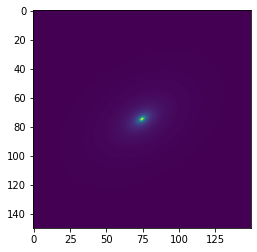

In [4]:
image = sersic_light_profile.image_2d_from_grid(grid=grid)

plt.imshow(image.native) # The use of 'native' is described at the start of the HowToLens tutorials.

The PyAutoLens plot module provides methods for plotting objects and their properties, like the image of
a `LightProfile`.

Note how, unlike the matplotlib method above, this figure is displayed with axis units of arc-seconds, a colorbar,
labels, a title, etc. The **PyAutoLens** plot module takes care of all the heavy lifting that comes with making figures!

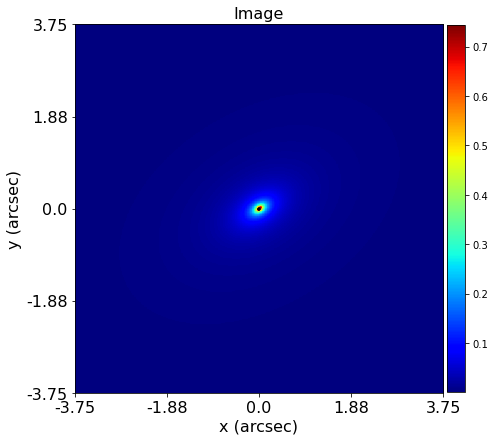

In [5]:
light_profile_plotter = aplt.LightProfilePlotter(
    light_profile=sersic_light_profile, grid=grid
)
light_profile_plotter.figures_2d(image=True)

**PyAutoLens** uses `MassProfile` objects to represent a galaxy's mass distribution and perform ray-tracing
calculations.

Below we create an elliptical isothermal `MassProfile` and compute its deflection angles on our Cartesian grid, where
the deflection angles describe how the lens galaxy's mass bends the source's light:

In [6]:
isothermal_mass_profile = al.mp.EllIsothermal(
    centre=(0.0, 0.0), elliptical_comps=(0.1, 0.0), einstein_radius=1.6
)

deflections = isothermal_mass_profile.deflections_2d_from_grid(grid=grid)

The deflection angles are easily plotted using the **PyAutoLens** plot module.

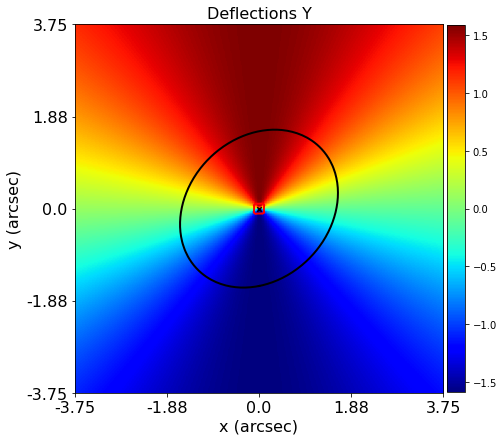

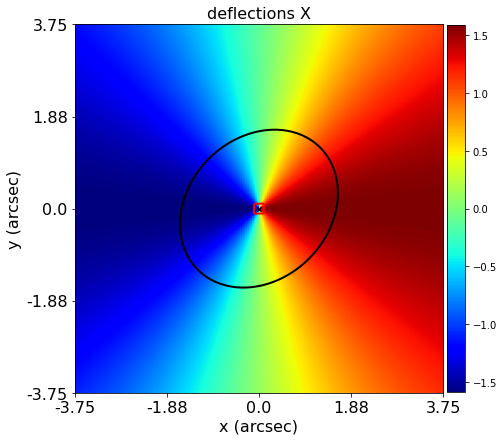

In [7]:
mass_profile_plotter = aplt.MassProfilePlotter(
    mass_profile=isothermal_mass_profile, grid=grid
)
mass_profile_plotter.figures_2d(
    deflections_y=True, deflections_x=True
)

Many other lensing quantities are easily plotted with the `MassProfilePltoter`.

For readers unsure what the plotted quantities below mean, they are described in detail in chapter 1 of
the **HowToLens** Jupyter notebook lectures:

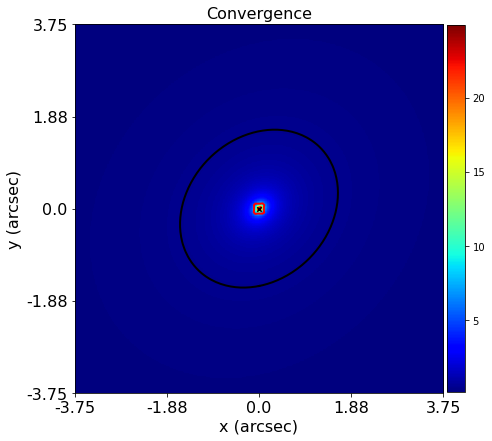

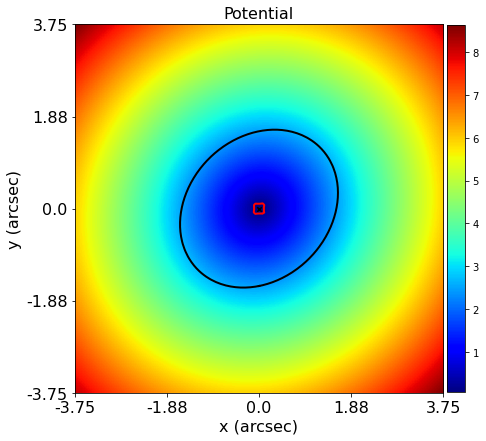

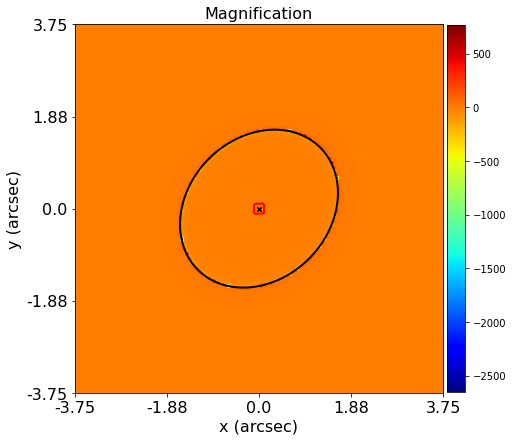

In [8]:
mass_profile_plotter.figures_2d(
    convergence=True,
    potential=True,
    magnification=True,
)

In **PyAutoLens**, a `Galaxy` object is a collection of `LightProfile` and `MassProfile` objects at a given redshift.

The code below creates two galaxies representing the lens and source galaxies shown in the strong lensing diagram above.

In [9]:
lens_galaxy = al.Galaxy(
    redshift=0.5, light=sersic_light_profile, mass=isothermal_mass_profile
)

source_light_profile = al.lp.EllExponential(
    centre=(0.3, 0.2),
    elliptical_comps=(0.1, 0.0),
    intensity=0.1,
    effective_radius=0.5
)

source_galaxy = al.Galaxy(redshift=1.0, light=source_light_profile)

We can use a `GalaxyPlotter` to plot the properties of the lens and source galaxies.

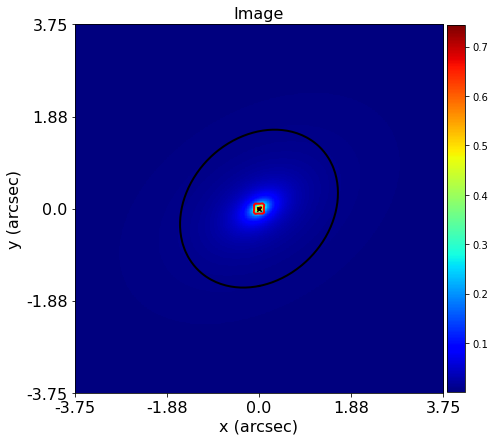

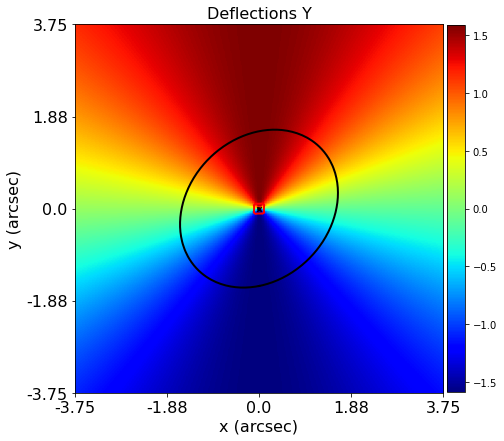

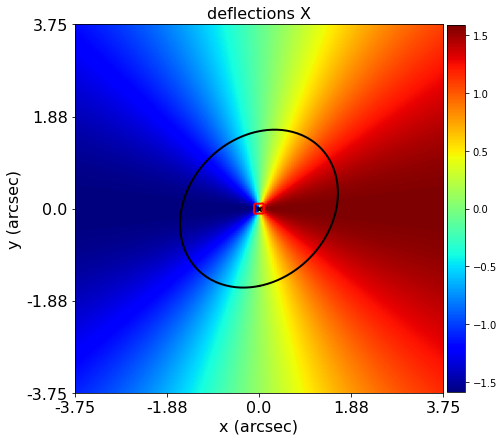

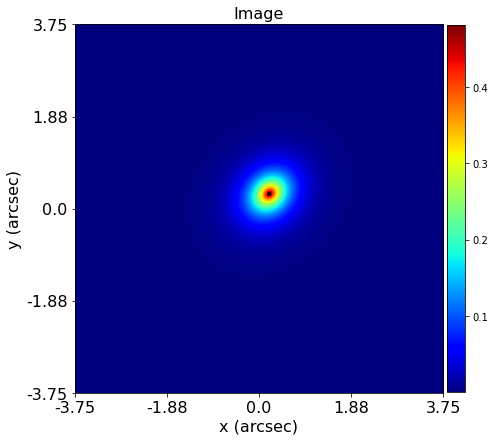

In [10]:
lens_galaxy_plotter = aplt.GalaxyPlotter(galaxy=lens_galaxy, grid=grid)
lens_galaxy_plotter.figures_2d(image=True, deflections_y=True, deflections_x=True)

source_galaxy_plotter = aplt.GalaxyPlotter(galaxy=source_galaxy, grid=grid)
source_galaxy_plotter.figures_2d(image=True)

The geometry of the strong lens system depends on the cosmological distances between the Earth, the lens galaxy and
the source galaxy. It therefore depends on the redshifts of the `Galaxy` objects.

By passing these `Galaxy` objects to a `Tracer`, **PyAutoLens** uses these galaxy redshifts and a cosmological model
to create the appropriate strong lens system.

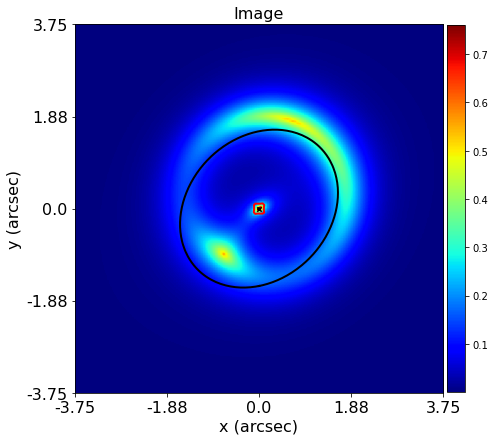

In [11]:
tracer = al.Tracer.from_galaxies(
    galaxies=[lens_galaxy, source_galaxy], cosmology=cosmo.Planck15
)

image = tracer.image_2d_from_grid(grid=grid)

tracer_plotter = aplt.TracerPlotter(tracer=tracer, grid=grid)
tracer_plotter.figures_2d(image=True)

The `TracerPlotter` includes the `MassProfile` quantities we plotted previously, which can be plotted as a subplot
that plots all these quantities simultaneously.

All of the objects introduced above are extensible. `Galaxy` objects can take many `Profile`'s and `Tracer`'s
many `Galaxy`'s.

If the galaxies are at different redshifts a strong lensing system with **multiple lens planes** will be created,
performing complex **multi-plane** ray-tracing calculations.

To finish, lets create a `Tracer` with 3 galaxies at 3 different redshifts, forming a system with two distinct Einstein
rings! The mass distribution of the first galaxy has separate components for its stellar mass and dark matter, where
the stellar components use a `LightAndMassProfile` via the `lmp` module.

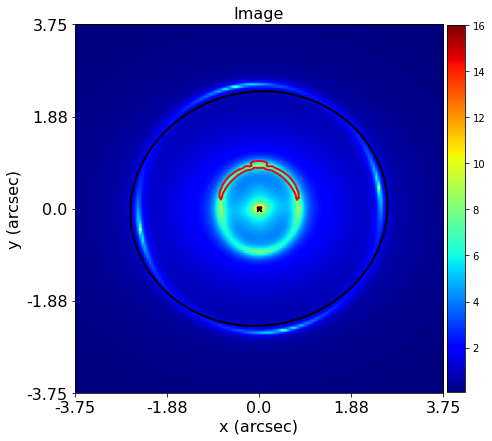

In [12]:
lens_galaxy_0 = al.Galaxy(
    redshift=0.5,
    bulge=al.lmp.EllSersic(
        centre=(0.0, 0.0),
        elliptical_comps=(0.0, 0.05),
        intensity=0.5,
        effective_radius=0.3,
        sersic_index=3.5,
        mass_to_light_ratio=0.6,
    ),
    disk=al.lmp.EllExponential(
        centre=(0.0, 0.0),
        elliptical_comps=(0.0, 0.1),
        intensity=1.0,
        effective_radius=2.0,
        mass_to_light_ratio=0.2,
    ),
    dark=al.mp.SphNFW(centre=(0.0, 0.0), kappa_s=0.08, scale_radius=30.0),
)

lens_galaxy_1 = al.Galaxy(
    redshift=1.0,
    bulge=al.lp.EllExponential(
        centre=(0.00, 0.00),
        elliptical_comps=(0.05, 0.05),
        intensity=1.2,
        effective_radius=0.1,
    ),
    mass=al.mp.EllIsothermal(
        centre=(0.0, 0.0), elliptical_comps=(0.05, 0.05), einstein_radius=0.6
    ),
)

source_galaxy = al.Galaxy(
    redshift=2.0,
    bulge=al.lp.EllSersic(
        centre=(0.0, 0.0),
        elliptical_comps=(0.0, 0.111111),
        intensity=0.7,
        effective_radius=0.1,
        sersic_index=1.5,
    ),
)

tracer = al.Tracer.from_galaxies(galaxies=[lens_galaxy_0, lens_galaxy_1, source_galaxy])

tracer_plotter = aplt.TracerPlotter(tracer=tracer, grid=grid)
tracer_plotter.figures_2d(image=True)

Chapter 1 of the **HowToLens** Jupyter notebook tutorials gives new users a full run through of lensing calculations
with **PyAutoLens** and introduces those not familiar with gravitational lensing to the core theory.

A more detailed overview of these calculations can also be found in `notebooks/overview/lensing.py`.

Lens Modeling
-------------

Lens modeling is the process of taking data of a strong lens (e.g. imaging data from the Hubble Space Telescope or
interferometer data from ALMA) and fitting it with a lens model, to determine the `LightProfile`'s and `MassProfile`'s
that best represent the observed strong lens.

Lens modeling with **PyAutoLens** uses the probabilistic programming language
[PyAutoFit](https://github.com/rhayes777/PyAutoFit), an open-source project that allows complex model
fitting techniques to be straightforwardly integrated into scientific modeling software. Check it out if you
are interested in developing your own software to perform advanced model-fitting!

We import **PyAutoFit** separately to **PyAutoLens**

In [13]:
import autofit as af

In this example, we consider Hubble Space Telescope imaging of the strong lens SLACS2303+1422. First, lets load this
imaging dataset and plot it.

Note that the luminous emission of the foreground lens galaxy has been pre-subtracted in this image, to better
highlight the source.

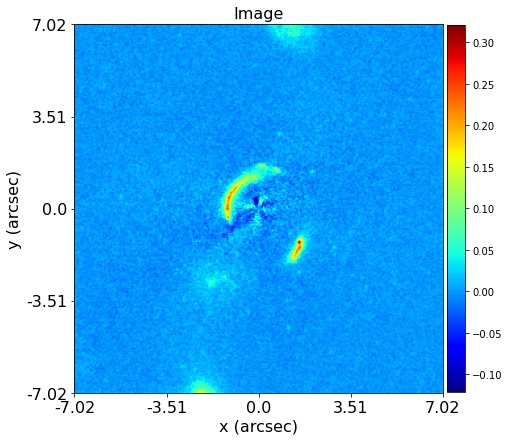

In [14]:
dataset_path = path.join("dataset", "slacs", "slacs2303+1422")

imaging = al.Imaging.from_fits(
    image_path=path.join(dataset_path, "image.fits"),
    psf_path=path.join(dataset_path, "psf.fits"),
    noise_map_path=path.join(dataset_path, "noise_map.fits"),
    pixel_scales=0.05,
)

imaging_plotter = aplt.ImagingPlotter(imaging=imaging)
imaging_plotter.figures_2d(image=True)

We next mask the dataset, to remove the exterior regions of the image that do not contain emission from the lensed
source galaxy.

Note how when we plot the `Imaging` below, the figure now zooms into the masked region.

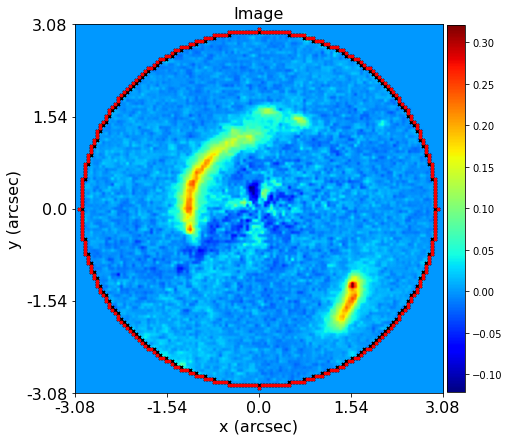

In [15]:
mask = al.Mask2D.circular(
    shape_native=imaging.shape_native,
    pixel_scales=imaging.pixel_scales,
    radius=3.0
)

imaging = imaging.apply_mask(mask=mask)

imaging_plotter = aplt.ImagingPlotter(imaging=imaging)
imaging_plotter.figures_2d(image=True)


We now compose the lens model that we fit to the data using `Model` objects. This behave analogously to the `Galaxy`,
`LightProfile` and `MassProfile` objects above, however their parameters are not specified and are instead determined
by a fitting procedure.

We will fit our strong lens data with two galaxies:

- A lens galaxy with an `EllIsothermal` `MassProfile` representing its mass.
- A source galaxy with an `EllExponential` `LightProfile` representing a disk.

The redshifts of the lens (z=0.5) and source(z=1.0) are fixed.

In [16]:
lens_galaxy_model = af.Model(
    al.Galaxy,
    redshift=0.5,
    mass=al.mp.EllIsothermal
)

source_galaxy_model = af.Model(al.Galaxy, redshift=1.0, disk=al.lp.EllExponential)

We combine the lens and source model galaxies above into a `Collection`, which is the model we will fit. Note how
we could easily extend this object to compose highly complex models containing many galaxies.

In [17]:
model = af.Collection(lens=lens_galaxy_model, source=source_galaxy_model)

By printing the `Model`'s we see that each parameters has a prior associated with it, which is used by the
model-fitting procedure to fit the model.

In [18]:
print(lens_galaxy_model)
print()
print(source_galaxy_model)


Galaxy (centre_0, GaussianPrior, mean = 0.0, sigma = 0.1), (centre_1, GaussianPrior, mean = 0.0, sigma = 0.1), (elliptical_comps_0, GaussianPrior, mean = 0.0, sigma = 0.3), (elliptical_comps_1, GaussianPrior, mean = 0.0, sigma = 0.3), (einstein_radius, UniformPrior, lower_limit = 0.0, upper_limit = 3.0)

Galaxy (centre_0, GaussianPrior, mean = 0.0, sigma = 0.3), (centre_1, GaussianPrior, mean = 0.0, sigma = 0.3), (elliptical_comps_0, GaussianPrior, mean = 0.0, sigma = 0.5), (elliptical_comps_1, GaussianPrior, mean = 0.0, sigma = 0.5), (intensity, LogUniformPrior, lower_limit = 1e-06, upper_limit = 1000000.0), (effective_radius, UniformPrior, lower_limit = 0.0, upper_limit = 30.0)


We now choose the 'non-linear search', which is the fitting method used to determine the set of `LightProfile`
and `MassProfile` parameters that best-fit our data.

In this example we use [dynesty](https://github.com/joshspeagle/dynesty), a nested sampling algorithm that in our
experience has proven very effective at lens modeling.

In [19]:
search = af.DynestyStatic(name="overview_example")

To perform the model-fit, we create an `AnalysisImaging` object which contains the `log likelihood function` that the
non-linear search calls to fit the lens model to the data.

In [20]:
analysis = al.AnalysisImaging(dataset=imaging)

To perform the model-fit we pass the model and analysis to the search's fit method. This will output results (e.g.,
dynesty samples, model parameters, visualization) to hard-disk.

However, the lens modeling of this system takes 10-20 minutes. Therefore, to save time in this introduction, we have
commented out the `fit` function below so you can skip through to the next section of the notebook. Feel free to
uncomment the code and run the lens modeling yourself!

Once a model-fit is running, **PyAutoLens** outputs the results of the search to hard-disk on-the-fly. This includes
lens model parameter estimates with errors non-linear samples and the visualization of the best-fit lens model inferred
by the search so far.

In [21]:
# result = search.fit(model=model, analysis=analysis)

The animation below shows a slide-show of the lens modeling procedure. Many lens models are fitted to the data over
and over, gradually improving the quality of the fit to the data and looking more and more like the observed image.

![Lens Modeling Animation](https://github.com/Jammy2211/auto_files/blob/main/lensmodel.gif?raw=true "model")

**Credit: Amy Etherington**

The fit returns a `Result` object, which contains the best-fit `Tracer` and `FitImaging` as well as the full
posterior information of the non-linear search, including all parameter samples, log likelihood values and tools to
compute the errors on the lens model.

Examples on the `autolens_workspace` describe how to use process the results of a lens-model fit.

Chapter 2 of the **HowToLens** Jupyter notebook tutorials gives new users a full run through of lens modeling,
including a primer on Bayesian statistics, how a non-linear search works and effective strategies for fitting data of a
strong lens.

Examples can also be found in the `notebooks/overview/modeling.py` and `notebooks/imaging/modeling` packages.

Simulating Lenses
-----------------

**PyAutoLens** provides tool for simulating strong lens data-sets, which can be used to test lens modeling pipelines
and train neural networks to recognise and analyse images of strong lenses.

Simulating strong lens images uses a `SimulatorImaging` object, which models the process that an instrument like the
Hubble Space Telescope goes through observe a strong lens. This includes accounting for the exposure time to
determine the signal-to-noise of the data, accounting for diffraction of the observed light by the telescope optics
and accounting for the background sky in the exposure which acts as a source of noise.

In [22]:
psf = al.Kernel2D.from_gaussian(shape_native=(11, 11), sigma=0.1, pixel_scales=0.05)

simulator = al.SimulatorImaging(
    exposure_time=300.0, background_sky_level=1.0, psf=psf, add_poisson_noise=True
)

Once we have a simulator, we can use it to create an imaging dataset which consists of an image, noise-map and
Point Spread Function (PSF) by passing it a tracer and grid.

This uses the tracer above to create the image of the strong lens and then add the effects that occur during data
acquisition.

In [23]:
imaging = simulator.from_tracer_and_grid(tracer=tracer, grid=grid)

By plotting a subplot of the `Imaging` dataset, we can see this object includes the observed image of the strong lens
(which has had noise and other instrumental effects added to it) as well as a noise-map and PSF:

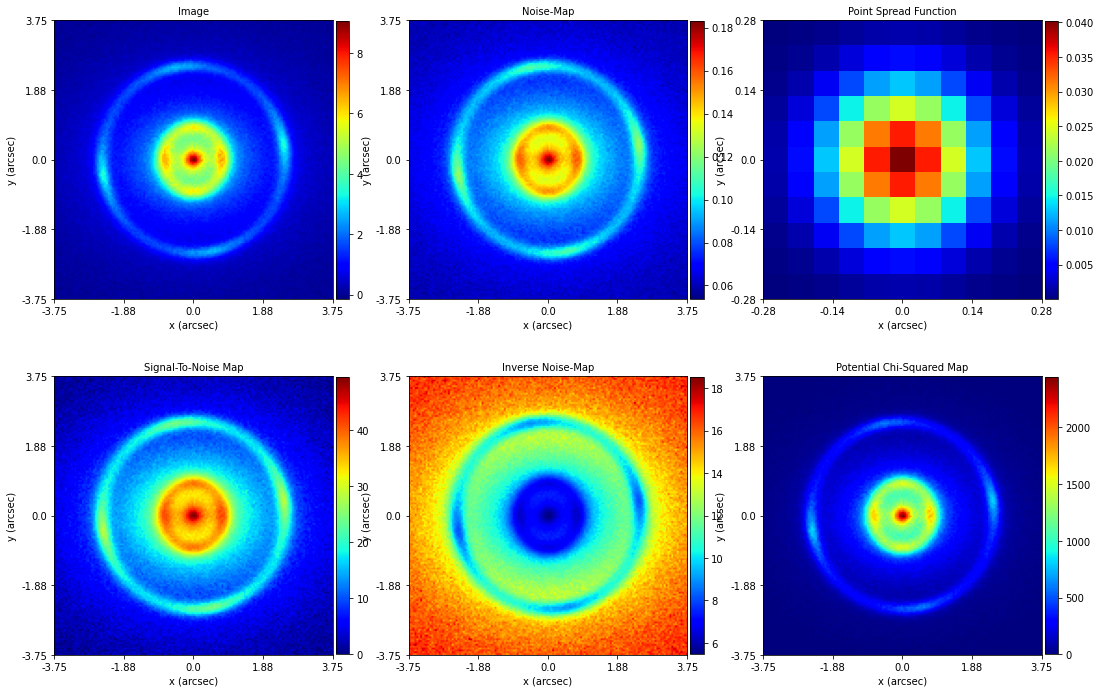

In [24]:
imaging_plotter = aplt.ImagingPlotter(imaging=imaging)
imaging_plotter.subplot_imaging()

The folder `notebooks/imaging/simulators` includes many example notebooks for simulating strong lenses with a range
of different physical properties as well as creating imaging datasets representative of a variety of telescopes
(e.g. Hubble, Euclid).

Below, we show what a strong lens observation looks like for the lowest resolution instrument in these examples (the
Vera Rubin Observatory) and highest resolution instrument (Keck Adaptive Optics).

![vro](https://raw.githubusercontent.com/Jammy2211/PyAutoLens/master/docs/overview/images/simulating/vro_image.png)

![ao](https://raw.githubusercontent.com/Jammy2211/PyAutoLens/master/docs/overview/images/simulating/ao_image.png)

Pixelizations
-------------

Pixelizations reconstruct the source galaxy's light on a pixel-grid. Unlike `LightProfile`'s, they are able to
reconstruct the light of non-symmetric, irregular and clumpy sources.

The image below shows a pixelized source reconstruction of the strong lens SLACS1430+4105, where the source is
reconstructed on a Voronoi-mesh adapted to the source morphology, revealing it to be a grand-design face on spiral
galaxy:

![Pixelized Source](https://github.com/Jammy2211/PyAutoLens/blob/master/files/imageaxis.png?raw=true)

A complete overview of pixelized source reconstructions can be found at `notebooks/overview/pixelizations.ipynb`.
Chapter 4 of the **HowToLens** lectures describes `Pixelization`'s in detail and teaches users how they can be used to
perform lens modeling.

Interferometry
--------------

**PyAutoLens** supports modeling of interferometer data from submillimeter and radio observatories.

Visibilities data is fitted directly in the uv-plane, circumventing issues that arise when fitting a dirty image
such as correlated noise. This uses the non-uniform fast fourier transform algorithm
[PyNUFFT](https://github.com/jyhmiinlin/pynufft) to efficiently map the lens model images to the uv-plane.

Given the irregular and clumpy nature of submm / radio sources, pixelized source reconstructions are vital for
modeling interferometer datasets. This would be a slow process,  however **PyAutoLens*** uses the linear algebra
library [PyLops](https://pylops.readthedocs.io/en/latest/) to ensure visibilities fitting is efficient, even for
datasets consisting of **tens of millions** of visibilities.

An overview of interferometer analysis is given in `notebooks/overview/interferometer.ipynb` and
the `autolens_workspace/notebooks/interferometer` package has example scripts for simulating datasets and lens modeling.

Congratulations, you've completed the **PyAutoLens** overview!

So, What Next?
--------------

We recommend that new users start with the **HowToLens** Jupyter notebook tutorials, which provide a detailed
description of the **PyAutoLens** API and teach new users how to approach lens analysis, modeling and use the
features described above.

You can install **PyAutoLens** on your system and clone the `autolens_workspace` and `howtolens` tutorials
following the instructions on our readthedocs:

 https://pyautolens.readthedocs.io/en/latest/installation/overview.html

Alternatively, you can begin the tutorials on this Binder by going to the
folder `notebooks/howtolens/chapter_1_introduction`.

If you want to dive straight into a certain feature, example scripts for the following tasks can be found in the
following folders of the `autolens_workspace`:

- `notebooks/overview`: A more detailed overview of **PyAutoLens**'s features .
- `notebooks/imaging/modeling`: Example scripts for fitting a lens model to CCD imaging data (e.g. HST).
- `autolens_workspace/notebooks/imaging/modeling/results.ipynb`: The contents of the `Result` object returned after lens modeling.
- `notebooks/imaging/preprocess` A Preprocessing guide for preparing your CCD dataset for **PyAutoLens**.
- `notebooks/imaging/simulators`: Simulating CCD imaging data.
- `notebooks/interferometer`: Interferometer modeling and simulations.
- `notebooks/plot`: Plotting examples and API reference .

Examples describing advanced **PyAutoLens** features are also located on the `autolens_workspace`, we advise that
new users omit these packages until familiar with the software:

- `notebooks/imaging/modeling/chaining`: Advanced modeling scripts which chain together multiple non-linear searches.
- `notebooks/database`: Database tools for loading and analysing the results of large-scale lens model fits.
- `notebooks/imaging/chaining/hyper_mode`: Examples using hyper-mode, which adapts the lens model to the data being fitted.
- `slam`: The SLaM (Source, Light and Mass) lens modeling pipelines, which fully automate fitting complex lens models
  but utilize all of **PyAutoLens**'s advanced modeling features!